# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv1_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version:    2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [1]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz

In [21]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import scooby # Reports Python environment

In [4]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz']))


--------------------------------------------------------------------------------
  Date: Thu Oct 06 13:51:53 2022 Central Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC
  v.1929 64 bit (AMD64)]

            pandas : 1.5.0
          pyincore : 1.7.0
      pyincore_viz : Version unknown
             numpy : 1.23.3
             scipy : 1.9.1
           IPython : 8.5.0
        matplotlib : 3.6.0
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [5]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

In [35]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/
communities = {'SaltLakeCity_UT' : {
                    'community_name' : 'Salt Lake City, UT',
                    'STATE' : 'UTAH',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '49035', 'Name' : 'Salt Lake City County, UT'}}}}

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [7]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.7.0


In [8]:
# create data_service object for loading files
data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

In [20]:
version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

Generating Housing Unit Inventory v2.0.0 data for Salt Lake City, UT
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Housing Unit Inventory v2.0.0 data for Salt Lake City, UT: 1
Dataset Housing Unit Inventory v2.0.0 data for Salt Lake City, UT already exists in IN-CORE
Dataset already exists in IN-CORE with filename hui_v2-0-0_SaltLakeCity_UT_2010_rs1000.csv
Use dataset_id: 630e8b03f5438e1f8c51d7c2
Dataset already exists on IN-CORE, use dataset_id: 630e8b03f5438e1f8c51d7c2


In [10]:
# Housing Unit inventory
housing_unit_inv_id = hui_dataset_id
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\630e8b03f5438e1f8c51d7c2\hui_v2-0-0_SaltLakeCity_UT_2010_rs1000\hui_v2-0-0_SaltLakeCity_UT_2010_rs1000.csv


In [11]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")

In [12]:
housing_unit_inv_df['huid'].describe()

count                   364210
unique                  364210
top       B490351001001006H001
freq                         1
Name: huid, dtype: object

## Read in Building Inventory

In [13]:
# Building inventory
bldg_inv_id = "62fea288f5438e1f8c515ef8" # SLC building inventory - Milad Roohi
# load building inventory
bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
filename = bldg_inv.get_file_path('shp')
print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\62fea288f5438e1f8c515ef8\Salt Lake County All Building\Salt Lake County All Building.shp


In [14]:
bldg_inv_gdf = gpd.read_file(filename)
# Check CRS of building inventory
bldg_inv_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
from pyproj import CRS
# Update CRS to EPSG:4326 if not already in that format
if bldg_inv_gdf.crs != CRS.from_epsg(4326):
    bldg_inv_gdf = bldg_inv_gdf.to_crs(epsg=4326)
    print("The CRS of the building inventory has been updated to EPSG:4326")
else:
    print("The CRS of the building inventory is already in EPSG:4326")

The CRS of the building inventory is already in EPSG:4326


In [16]:
# Check Unique ID
bldg_inv_gdf[['guid','bldg_id']].astype(str).describe().T

,count,unique,top,freq
guid,284925,284925,6f8c3468-4696-4371-bc91-3a7ceec1e768,1
bldg_id,284925,112,16200000000000.0,17249


In [17]:
bldg_inv_gdf.head(1).T

,0
parid,28200000000000.0
parid_card,28200000000000.0
bldg_id,28200000000000.0
struct_typ,RM1L
archetype,COM3
str_prob,None
year_built,1993
no_stories,1
a_stories,None
b_stories,None


In [43]:
# What variable has information to determine if building is residential or not?
# County observations by variable
bldg_inv_gdf[['archetype','occ_type','guid']].groupby(['archetype','occ_type']).count()

,,guid
archetype,occ_type,
AGR1,AGR1,57
COM1,COM1,7900
COM10,COM10,373
COM2,COM2,4674
COM3,COM3,2096
COM4,COM4,5674
COM5,COM5,270
COM6,COM6,217
COM7,COM7,421


#### HAZUS Occupancy Status
Table 3-1: Hazus Occupancy Class Definitions

| Label             | Hazus Occupancy Class            |
|-------------------|----------------------------------|
|                   | Residential                      |
| RES1              | Single Family Dwelling           |
| RES2              | Mobile / Manufactured Home       |
| RES3A            | RES3A Duplex                      |
| RES3B            | RES3B 3-4 Units                   |
| RES3C  |  5-9 Units                 |
| RES3D  |  10-19 Units                         |
| RES3E  |   20-49 Units                      |
| RES3F |   50+ Units                       |
| RES4              | Temporary Lodging                |
| RES5              | Institutional Dormitory          |
| RES6              | Nursing Home                     |
|-------|------------------------------------|
|                   | Commercial                       |
| COM1              | Retail Trade                     |
| COM2              | Wholesale Trade                  |
| COM3              | Personal and Repair Services     |
| COM4              | Professional/Technical Services  |
| COM5  | Banks                              |
| COM6  | Hospital                           |
| COM7  | Medical Office/Clinic              |
| COM8  | Entertainment & Recreation         |
| COM9  | Theaters                           |
| COM10 | Parking                            |
|------|------------------------|
|       | Industrial                         |
|------|------------------------|
| IND1  | Heavy                              |
| IND2  | Light                              |
| IND3  | Food/Drugs/Chemicals               |
| IND4  | Metals/Minerals Processing         |
| IND5  | High Technology                    |
| IND6  | Construction                       |
|------|------------------------|
|       | Agriculture                        |
|------|------------------------|
| AGR1  | Agriculture                        |
|       | Religion/Membership Organizations  |
| REL1  | Church/Nonprofit                   |
|------|------------------------|
|       | Government                         |
|------|------------------------|
| GOV1  | General Services                   |
| GOV2  | Emergency Response                 |
|------|------------------------|
|      | Education              |
|------|------------------------|
| EDU1 | Grade School, Library  |
| EDU2 | College/University     |


### Find Spatial Extent of Building Inventory
Need to know which counties are included in the building inventory.

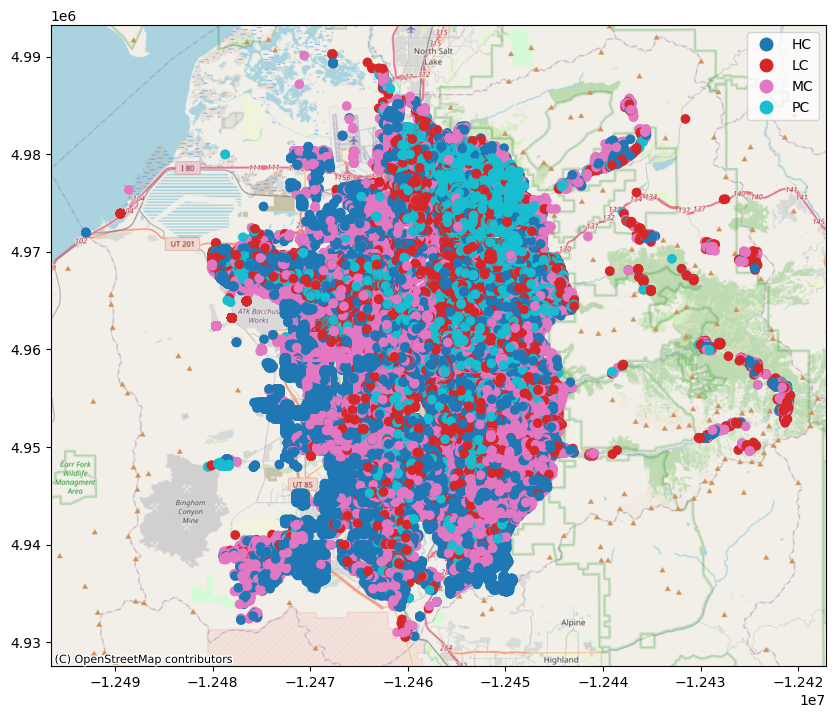

In [18]:
map = viz.plot_gdf_map(bldg_inv_gdf,column='dlevel')
map

#### Use Tract ID to find county FIPS code
The first 5 digits of the tract ID are the FIPS code for the county.

In [15]:
bldg_inv_gdf['tract_id'].describe()

count    2.849250e+05
mean     4.903511e+10
std      4.125693e+03
min      4.903510e+10
25%      4.903511e+10
50%      4.903511e+10
75%      4.903511e+10
max      4.903511e+10
Name: tract_id, dtype: float64

In [16]:
# Substring of tractid to get county 5 digit fips code 
# covert tract_id to string with leading zeros
bldg_inv_gdf['tract_id_str'] = bldg_inv_gdf['tract_id'].astype(str).str.zfill(11)
bldg_inv_gdf['county'] = bldg_inv_gdf['tract_id_str'].str[:5]
bldg_inv_gdf[['tract_id_str','county']].describe()

,tract_id_str,county
count,284925,284925
unique,193,1
top,49035113104,49035
freq,8331,284925


### Building Inventory File has 1 county
The Salt Late City building inventory only has 1 county.

## Generate Address Point Inventory


In [44]:
Nofal_residential_archetypes = { 
        1 : 'One-story sf residential building on a crawlspace foundation',
        2 : 'One-story mf residential building on a slab-on-grade foundation',
        3 : 'Two-story sf residential building on a crawlspace foundation',
        4 : 'Two-story mf residential building on a slab-on-grade foundation'}

HAZUS_residential_archetypes = { 
    "RES1" : "Single Family Dwelling",
    "RES2" : "Mobile / Manufactured Home",
    "RES3A" : "Duplex",
    "RES3B" : "3-4 Units",
    "RES3C" : "5-9 Units",
    "RES3D" : "10-19 Units",
    "RES3E" : "20-49 Units",
    "RES3F" : "50+ Units",
    "RES4" : "Temporary Lodging",
    "RES5" : "Institutional Dormitory",
    "RES6" : "Nursing Home"
    }

residential_archetypes = HAZUS_residential_archetypes 

In [45]:
generate_addpt_df = generate_addpt_functions(
                    communities =   communities,
                    hui_df = housing_unit_inv_df,
                    bldg_inv_gdf = bldg_inv_gdf,
                    bldg_inv_id = bldg_inv_id,
                    residential_archetypes = residential_archetypes,
                    archetype_var = 'archetype',
                    building_area_var = 'sq_foot',
                    building_area_cutoff = 300,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder
                    )

addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

Estimating up Housing Units per Building for Salt Lake City, UT
Salt Lake City County, UT : county FIPS Code 49035
Checking if file exists: OutputData/SaltLakeCityCounty_UT/01_CommunitySourceData/tl_2010_49035_tabblockplacepuma10EPSG4269.csv
File exists. Skipping. Use replace=True to overwrite.
Block data already exists for  49035
Converting blk104269 to Geodataframe


c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data\pyncoda\ncoda_00e_geoutilities.py:97: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  polygon_gdf.loc[polygon_gdf.index, f'rppnt{yr}{epsg}'] =\
c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data\pyncoda\ncoda_00e_geoutilities.py:106: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  polygon_gdf.loc[polygon_gdf.index, f'blk{yr}{epsg}'] = polygo

Polygon file has 14935 block polygons.
Identified 14899 block polygons to spatially join.


c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data\pyncoda\ncoda_00e_geoutilities.py:273: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  points_gdf.loc[points_gdf.index,'geometry'] = points_gdf[point_var]


......................................................................................................................................................

c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data\pyncoda\ncoda_00e_geoutilities.py:294: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  points_gdf.loc[points_gdf.index,'geometry'] = points_gdf[poly_var]


226455 Buildings have Residential Archetype RES1
1222 Buildings have Residential Archetype RES2
19782 Buildings have Residential Archetype RES3A
3011 Buildings have Residential Archetype RES3B
637 Buildings have Residential Archetype RES3C
548 Buildings have Residential Archetype RES3D
573 Buildings have Residential Archetype RES3E
2684 Buildings have Residential Archetype RES3F
438 Buildings have Residential Archetype RES4
276 Buildings have Residential Archetype RES5
133 Buildings have Residential Archetype RES6
1998 Buildings have building_area_var less than 300
0 Buildings have  sq_foot _by_AP less than 300
255583 Buildings assigned residential.
Total number of expected housing unit address points in county: 364210
10136 buildings are in blocks with no housing units.
For Round 1 Estimated Residential Address Points correlation: 0.563
1. HU=0 had 873 observations
2. HU=AP had 5114 observations
3. HU<AP had 1028 observations
8. HU > 0, Building Count = Missing had 0 observations
9. H

### Read in Address Point Inventory
The address point inventory is an intermediate file based on the building inventory. The address point inventory acts as the bridge between the building inventory and the housing unit inventory.

In [ ]:
# Address Point inventory
addpt_inv_id = "60aac382088dfa3b65030b16"
# load housing unit inventory as pandas dataframe
addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
filename = addpt_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)

In [ ]:
addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

## Step 2: Housing Unit Allocation v2

### Setup notebook environment to access Cloned Github Package
This notebook uses functions that are in development. The current version of the package is available at:

https://github.com/npr99/intersect-community-data

Nathanael Rosenheim. (2022). npr99/intersect-community-data. Zenodo. https://doi.org/10.5281/zenodo.6476122

A permanent copy of the package and example datasets are available in the DesignSafe-CI repository:

Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

In [ ]:
#To replicate this notebook Clone the Github Package to a folder that is a sibling of this notebook.
# To access the sibling package you will need to append the parent directory ('..') to the system path list.
# append the path of the directory that includes the github repository.
# This step is not required when the package is in a folder below the notebook file.
github_code_path  = ""
sys.path.append(github_code_path)

In [ ]:
os.getcwd()

### Setup Housing Unit Allocation

In [ ]:
# Example of data dictionary for one community with one county
communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}}}}

In [ ]:
version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"
# Make directory to save output
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Set random seed for reproducibility
seed = 1000
basevintage = 2010


### Run Housing Unit Allocation

In [ ]:
for community in communities.keys():
    # Create empty container to store outputs for in-core
    # Will use these to combine multiple counties
    hua_incore_county_df = {}
    print("Setting up Housing Unit Inventory for",communities[community]['community_name'])
    for county in communities[community]['counties'].keys():
        state_county = communities[community]['counties'][county]['FIPS Code']
        state_county_name  = communities[community]['counties'][county]['Name']
        print(state_county_name,': county FIPS Code',state_county)
    
        outputfolders = directory_design(state_county_name = state_county_name,
                                            outputfolder = outputfolder)
                                            
        generate_df = hua_workflow_functions(
            hui_df = housing_unit_inv_df,
            addpt_df=addpt_inv_df,
            bldg_df=bldg_inv_gdf,
            state_county = state_county,
            state_county_name= state_county_name,
            seed = seed,
            version = version,
            version_text = version_text,
            basevintage = basevintage,
            outputfolder = outputfolder,
            outputfolders = outputfolders)

        # Generate base housing unit inventory
        base_hua_df = generate_df.run_hua_workflow(savelog=False)

        # Save version for IN-CORE in v2 format
        hua_incore_county_df[state_county] = base_hua_df['primary']

    # combine multiple counties
    hua_incore_df = pd.concat(hua_incore_county_df.values(), 
                                    ignore_index=True, axis=0)

    # Convert HUA to geodataframe format
    hua_incore_gdf = gpd.GeoDataFrame(
        hua_incore_df, geometry=gpd.points_from_xy(hua_incore_df.x, hua_incore_df.y))

    # Merge building inventory with housing unit allocation results
    huav2_gdf = pd.merge(left = hua_incore_gdf, 
                        right = bldg_inv_gdf[['guid','archetype','geometry']], 
                        on='guid', how='outer')

    # If Geometry is null, use X,Y coordinates from Address Point
    # use geometry_y unless missing - then use geometry_x
    huav2_gdf['geometry'] = huav2_gdf['geometry_y']
    huav2_gdf.loc[huav2_gdf['geometry'].isnull(), 'geometry'] = huav2_gdf['geometry_x']
    # drop geometry_x and geometry_y columns
    huav2_gdf.drop(columns=['geometry_x','geometry_y'], inplace=True)

    # Convert Block2010 to string
    # fill in missing values
    huav2_gdf['Block2010'] = huav2_gdf['Block2010'].fillna(371550000000000)
    huav2_gdf['Block2010'] = huav2_gdf['Block2010'].apply(lambda x : str(int(x)).zfill(15))

    #Save results for community name
    output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}'
    csv_filepath = outputfolders['top']+"/"+output_filename+'.csv'
    savefile = sys.path[0]+"/"+csv_filepath
    huav2_gdf.to_csv(savefile, index=False)

    # Save second set of files in common directory
    common_directory = outputfolders['top']+"/../"+output_filename
    huav2_gdf.to_csv(common_directory+'.csv', index=False)


## Check block with missing huid match


In [ ]:
from pyncoda.ncoda_04b_foliummaps import *

In [ ]:
# Check guid with missing address point id
condition1 = (huav2_gdf['guid'] == '099d5476-aaec-42d8-b0d1-e14eee17b373')
gdf1 = huav2_gdf.loc[condition1].copy()

folium_marker_layer_map(gdf = gdf1,
                        gdfvar="archetype",
                        layername = "",
                        color_levels = [0,1,2,3,4,5,6,7])